In [1]:
import time
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [3]:
device = 'cpu'

In [4]:
columns_config = {
    'numerical': ['square_feet', 'year_built', 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 
                 'sea_level_pressure', 'wind_speed', 'mean_target'],
    'categorical': [
        'site_id', 'building_id', 'primary_use', 
        'wind_direction_cat', 'month', 'hour', 'season', 'daytime']
}

In [5]:
class Net(nn.Module):
    def __init__(self, d_in=10, k=2, n_hidden=1, batch_norm=False, dropout=False):
        super(Net, self).__init__()
        d_cur = d_in
        self.layers = []
        for i in range(n_hidden):
            self.layers.append(nn.Linear(d_cur, d_cur // k))
            if batch_norm:
                self.layers.append(nn.BatchNorm1d(d_cur // k))
            self.layers.append(nn.ReLU())
            if dropout:
                self.layers.append(nn.Dropout())
            d_cur //= k
        self.layers.append(nn.Linear(d_cur, 1))
        self.layers = nn.ModuleList(self.layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [6]:
# Utils

# Prepare data

def select_meter(df, meter=1):
    df = df[df.meter == meter]
    df.drop(columns='meter', inplace=True)
    return df

def filter_wind(weather_df):
    weather_df.loc[weather_df.wind_direction + weather_df.wind_speed == 0, ['wind_direction', 'wind_speed']] = np.NaN
    return weather_df

def merge(data, weather, meta):
    df = meta.merge(data, on='building_id')
    df = df.merge(weather, on=['site_id', 'timestamp'])
    return df

def filter_zero_targets(df):
    df = df[df.meter_reading != 0]
    return df

def create_new_features(df):
    df['month'] = df.timestamp.apply(lambda x: time.strptime(x ,"%Y-%m-%d %H:%M:%S").tm_mon)
    df['hour'] = df.timestamp.apply(lambda x: time.strptime(x ,"%Y-%m-%d %H:%M:%S").tm_hour)
    
    df['season'] = df['month'] % 12 // 3
    df['daytime'] = df['hour'] // 5    
    return df

def prepare_data(meter=1, fast_debug=False, building_id=None):
    meta = pd.read_csv('data/building_metadata.csv')
    train = pd.read_csv('data/train.csv')
    weather = pd.read_csv('data/weather_train.csv')
    
    train = select_meter(train, meter)
    weather = filter_wind(weather)
    df = merge(train, weather, meta)
    
    if building_id:
        df = df[df.building_id == building_id]
    elif fast_debug:
        # building_ids = [1109, 1130, 1363, 1377]
        building_ids = np.random.choice(df.building_id.unique(), 1, replace=False)
        df = df[df.building_id.isin(building_ids)]

    df = filter_zero_targets(df)
    df = create_new_features(df)
    return df

# Preprocess data
class Preprocessor:
    def __init__(self, df):
        self.df = df
        
        self.train_idx = self.train_test_split()
        self.df = self.create_mean_target()
        self.df = self.fill_nans()
        self.df = self.create_wind_cat()
        
    def train_test_split(self):
        train_idx = np.random.choice(self.df.index, len(self.df) * 7 // 10, replace=False)
        return train_idx
        
    def create_mean_target(self):
        mean_targets = pd.DataFrame(data=self.df[self.df.index.isin(self.train_idx)].groupby('building_id').meter_reading.mean())
        mean_targets.columns = ['mean_target']
        
        df['tmp_index'] = df.index
        df.index = df.building_id
        df['mean_target'] = mean_targets
        df.index = df.tmp_index
        
        return self.df
    
    def fill_nans(self):
        for col in ['square_feet', 'year_built', 'floor_count', 'air_temperature', 'cloud_coverage', 'dew_temperature', 
                    'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']:
            self.df[col] = self.df[col].fillna(self.df.loc[self.train_idx, col].mean())
        return self.df
    
    def create_wind_cat(self):
        self.df['wind_direction_cat'] = self.df['wind_direction'] // 45
        return self.df

# Scale data
class Scaler:
    def __init__(self, preprocessor, batch_size=512):
        self.df = preprocessor.df
        self.train_idx = preprocessor.train_idx
        
        self.scaler_labels = None
        self.scaler_features = None
        self.encoders = {}
        
        self.create_scalers()
        
        cat_train, num_train, labels_train = self.transform(self.df.loc[self.train_idx])
        cat_test, num_test, labels_test = self.transform(self.df[~self.df.index.isin(self.train_idx)])
        self.d_in = cat_train.shape[1] + num_train.shape[1]
        
        self.testloader = self.create_dataloader(cat_test, num_test, labels_test, batch_size)
        self.trainloader = self.create_dataloader(cat_train, num_train, labels_train, batch_size)
  
    def create_scalers(self):
        self.scaler_features = StandardScaler()
        self.scaler_labels = StandardScaler()

        self.scaler_features.fit(self.df.loc[self.train_idx, columns_config['numerical']])
        self.scaler_labels.fit(self.df.loc[self.train_idx, 'meter_reading'].values.reshape(-1, 1))
        for col in columns_config['categorical']:
            self.encoders[col] = OneHotEncoder(handle_unknown='ignore', sparse=False)
            self.encoders[col].fit(self.df.loc[self.train_idx, col].values.reshape(-1, 1))
        
    def transform(self, data):
        num_features = self.scaler_features.transform(data.loc[:, columns_config['numerical']])
        labels = self.scaler_labels.transform(data.loc[:, 'meter_reading'].values.reshape(-1, 1))
        cat_features = []
        for col in columns_config['categorical']:
            cat_features.append(self.encoders[col].transform(data[col].values.reshape(-1, 1)))
        cat_features = np.concatenate(cat_features, axis=1)
        return cat_features, num_features, labels
    
    @staticmethod
    def create_dataloader(cat, num, labels, batch_size):
        dataset = TensorDataset(torch.Tensor(np.concatenate([cat, num], 1)).to(device), torch.Tensor(labels).to(device))
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        return dataloader
    
# Train
class Trainer:
    def __init__(self, scaler, net_config, lr=0.001):
        self.trainloader = scaler.trainloader
        self.testloader = scaler.testloader
        self.scaler_labels = scaler.scaler_labels

        self.optimizer = None
        self.criterion = None
        self.net = None
        
        net_config['d_in'] = scaler.d_in
        self.create_models(net_config, lr)
        
        self.train_losses = []
        self.test_losses = []
        self.metrics = []
        
    def create_models(self, net_config, lr):
        self.net = Net(**net_config).to(device)
        print('Net architecture:')
        print(self.net)
        
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.net.parameters(), lr=lr)
    
    def metric(self, pred, labels):
        pred_raw = self.scaler_labels.inverse_transform(pred.detach().cpu().numpy())
        labels_raw = self.scaler_labels.inverse_transform(labels.detach().cpu().numpy())
        pred_raw[pred_raw < 0] = 0
        loss =  np.mean((np.log(pred_raw + 1) - np.log(labels_raw + 1)) ** 2) ** 0.5
        return loss
    
    def train(self, n_epochs, verbose=True):
        for epoch in range(n_epochs):
            self.net.train()
            losses = []
            for i, data in enumerate(self.trainloader, 0):
                inputs, labels = data
                self.optimizer.zero_grad()
                outputs = self.net(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                losses.append(loss.item())
            if verbose:
                print('[%d] Train loss: %.3f' % (epoch + 1, np.mean(losses)))
            self.train_losses.append(np.mean(losses))

            self.net.eval()
            losses = []
            metrics = []
            for i, data in enumerate(self.testloader, 0):
                inputs, labels = data
                with torch.no_grad():
                    outputs = self.net(inputs)
                loss = self.criterion(outputs, labels)
                losses.append(loss.item())
                metrics.append(self.metric(outputs, labels))
            if verbose:
                print('[%d] Test loss: %.3f' % (epoch + 1, np.mean(losses)))
                print('[%d] Test metric: %.3f' % (epoch + 1, np.mean(metrics)))
            self.test_losses.append(np.mean(losses))
            self.metrics.append(np.mean(metrics))

    def plot(self):
        f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
        ax1.plot(self.train_losses, color='b')
        ax1.plot(self.test_losses, color='y')
        ax2.plot(self.metrics, color='y')
        plt.show()
        
    def save_model(self, name):
        torch.save(self.net, 'models/' + name)
        

In [7]:
train = pd.read_csv('data/train.csv')
meters = train.meter.unique()
buildings = train.building_id.unique()
del train

In [8]:
net_config = {
    'n_hidden': 1,
    'batch_norm': True,
    'dropout': True,
    'k': 3
}
    
for building in buildings:
    for meter in meters:
        df = prepare_data(meter=meter, building_id=building)
        preprocessor = Preprocessor(df)
        scaler = Scaler(preprocessor)
        trainer = Trainer(scaler, net_config, lr=0.001)
        trainer.train(150, verbose=False)
        print('Building %d, meter %d, last test loss %.4f, last test metric %.4f' % (building, meter, trainer.test_losses[-1],
                                                                                    trainer.metrics[-1]))
        trainer.save_model('model_%d_%d.pkl' % (building, meter))

C:\Users\foggy\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


KeyboardInterrupt: 

In [11]:
df = prepare_data(meter=0, building_id=0)

C:\Users\foggy\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [12]:
preprocessor = Preprocessor(df)

In [26]:
scaler = Scaler(preprocessor)

C:\Users\foggy\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\foggy\Anaconda3\lib\site-packages\ipykernel_launcher.py:116: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
C:\Users\foggy\Anaconda3\lib\site-packages\ipykernel_launcher.py:116: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


In [27]:
net_config = {
    'n_hidden': 1,
    'batch_norm': True,
    'dropout': True,
    'k': 3
}

trainer = Trainer(scaler, net_config, lr=0.001)

Net architecture:
Net(
  (layers): ModuleList(
    (0): Linear(in_features=63, out_features=21, bias=True)
    (1): BatchNorm1d(21, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5)
    (4): Linear(in_features=21, out_features=1, bias=True)
  )
)


In [28]:
trainer.train(150, verbose=False)

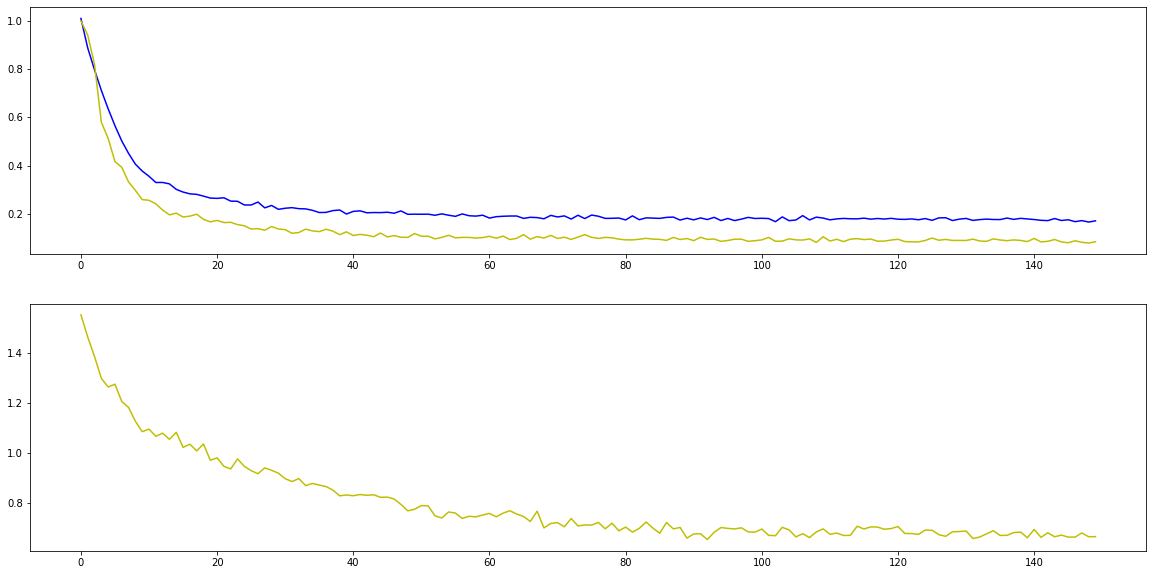

In [29]:
trainer.plot()

In [30]:
trainer.save_model('model_%d_%d.pkl' % (1, 0))

C:\Users\foggy\Anaconda3\lib\site-packages\torch\serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [191]:
df.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count,timestamp,meter_reading,air_temperature,cloud_coverage,...,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,month,hour,season,daytime,wind_direction_cat,mean_target
0,0,7,Education,121074,1989.0,16.018692,2016-02-29 09:00:00,1857.260,12.8,1.48275,...,0.0,1021.9,192.691301,3.512369,2,9,0,1,4.0,3399.992534
2,0,13,Education,99380,2000.0,16.018692,2016-02-29 09:00:00,1224.100,12.8,1.48275,...,0.0,1021.9,192.691301,3.512369,2,9,0,1,4.0,2204.615330
9,0,50,Other,4698,1981.0,16.018692,2016-02-29 09:00:00,2026.100,12.8,1.48275,...,0.0,1021.9,192.691301,3.512369,2,9,0,1,4.0,2716.414677
18,0,95,Lodging/residential,200933,2006.0,16.018692,2016-02-29 09:00:00,675.366,12.8,1.48275,...,0.0,1021.9,192.691301,3.512369,2,9,0,1,4.0,3043.963176
22,0,7,Education,121074,1989.0,16.018692,2016-02-29 10:00:00,2659.250,12.2,1.48275,...,0.0,1021.9,192.691301,3.512369,2,10,0,2,4.0,3399.992534


### Pseudocode pipeline

for metric in range(4):
    ### Do end-to-end pipeline
        
        ### Prepare data
        - load datasets
        - filter them accordingly
        - create new val-independent features

        ### Preprocess data (val or prod)
        - train-test split
        - create val-dependent features
        - apply them to train
        - apply them to test

        ### Scale data (val or prod)
        - create scalers
        - scale train
        - scale test
        - create tensors, datasets, dataloaders

        ### Train model
        - define models
        - train and val model
        - plot
        - save model
    

In [33]:
n_last_hours = 5
i = 2010

In [ ]:
weather_agg = []
for i in range(n_last_hours - 1, len(weather)):
    if i % 1000 == 0:
        print(i)
    row = weather[i - n_last_hours: i].mean()
    if row.site_id != weather.loc[i - 1].site_id:
        continue
    row['timestamp'] = weather.loc[i - 1].timestamp
    weather_agg.append(row)